In [1]:
import numpy as np
import pandas as pd
import time
import random
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers import Input, Conv2D
from keras.models import Model
from keras.models import load_model
from scipy import ndimage, misc
import gym
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def plot_state(obs):
    plt.figure(figsize=(12,8))
    plt.imshow(obs)
    plt.axis("off")
    plt.show()

In [3]:
def process_obs(obs):
    obs = obs.max(axis=-1,keepdims=1)
    obs = obs.reshape((210,160))
    obs = misc.imresize(obs, (110,84))
    lives = obs[2:9,52:59]
    obs = obs[18:102,:,]
    obs = np.expand_dims(obs,2)
    obs = obs.astype('float32') / 255
    obs[obs > 0] = 1
    return [obs,lives]

Welcome to AI Breakout!
Starting Test Game...



/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


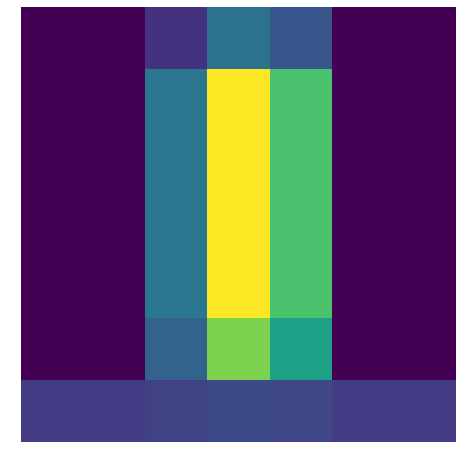

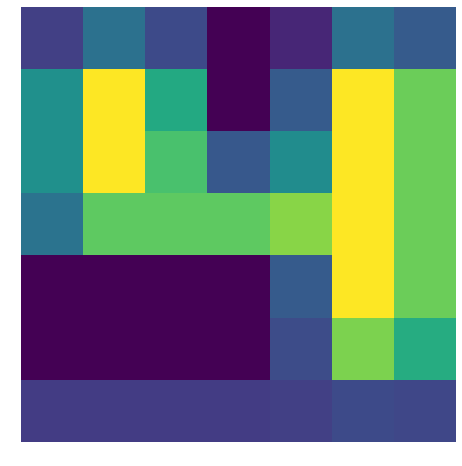

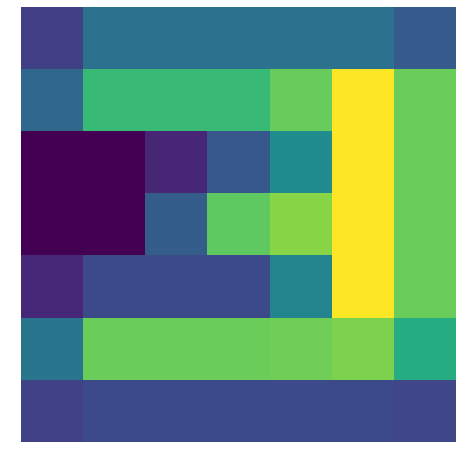

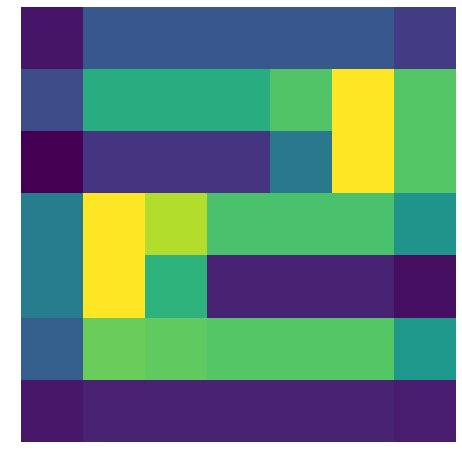

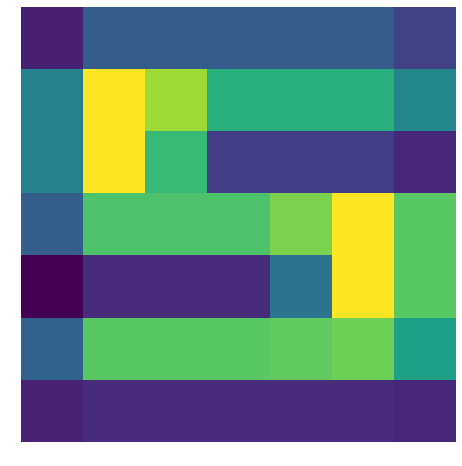

In [4]:
episodes = 1
env = gym.make("Breakout-v0")
init = env.reset()

for i in range(episodes):
    print("Welcome to AI Breakout!")
    print("Starting Test Game...\n")

    
    game = True
    LIVES = []
    while game:
        
        action = env.action_space.sample()
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        LIVES.append(lives)
        
        if done:
            
            LIVES = np.unique(np.array(LIVES), axis=0)
            
            for i in LIVES:
                plot_state(i.reshape(7,7))
            game = False
            observation = env.reset()
                             
        else:
            pass
            
         

In [5]:
env = gym.make("Breakout-v0")
init = env.reset()

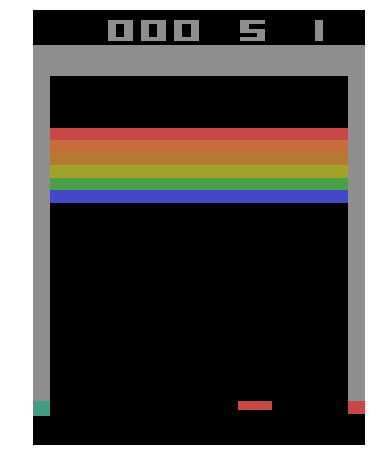

In [6]:
plot_state(init)

In [7]:
I = process_obs(init)[0]

/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


In [8]:
I.shape

(84, 84, 1)

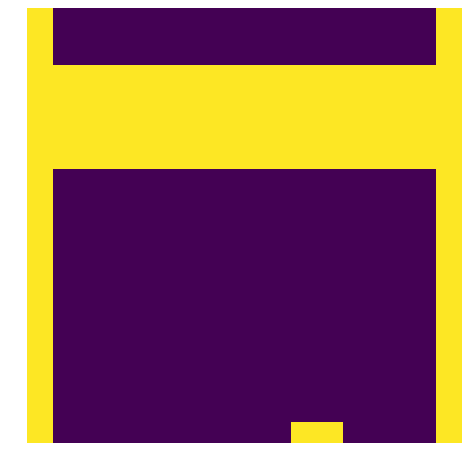

In [9]:
plot_state(I.reshape(84,84))

In [10]:
env.action_space

Discrete(4)

In [11]:
env.observation_space.shape

(210, 160, 3)

In [12]:
inp = Input(shape=(84,84,1))
x = Conv2D(16, (8,8), strides=4, activation="relu", input_shape=(84,84,1))(inp)
#x = Conv2D(16, (4,4), strides=2, activation="relu")(x)
x = Flatten()(x)
x = Dense(1024,  activation="relu")(x)
#x = Dense(16,  activation="relu")(x)
output = Dense(env.action_space.n)(x)

model = Model(inp, output)
callbacks_list = [keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.01, patience=2, mode = min, verbose = 1)]
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mae"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 84, 84, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 16)        1040      
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              6554624   
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 4100      
Total params: 6,559,764
Trainable params: 6,559,764
Non-trainable params: 0
_________________________________________________________________
None


/Users/samwilliams/homebrew/lib/python3.7/site-packages/keras/callbacks.py:1086: RuntimeWarning: Learning Rate Plateau Reducing mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


In [13]:
LIFE = {}
LIFE["1"] = LIVES[0]
LIFE["2"] = LIVES[3]
LIFE["3"] = LIVES[2]
LIFE["4"] = LIVES[1]
LIFE["5"] = LIVES[4]

In [14]:
for i,j in LIFE.items():
    print(i)

1
2
3
4
5


In [15]:
env = gym.make("Breakout-v0")
observation = env.reset()
observation, lives = process_obs(observation)

episodes = 1000
episode_scores = []
epsilon = 0.4
gamma = 0.9
done = False

history = {}


for i in range(1, episodes+1):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...\n".format(i, episodes))
    
    history = {"input":[], "reward":[], "action": [], "Q":[]}
    sum = 0
    frame = 0
    game = True
    LIVES = []
    while game: 
        
        if (frame == 0) or (frame % 4 == 0):
            rand = np.random.uniform(0,1)
            if  rand < epsilon:
                action = env.action_space.sample()
            else:
                observation = np.expand_dims(observation,0)
                action = np.argmax(model.predict(observation))
                
        else:
            pass
        
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        
        if len(LIVES) == 0:
            LIVES.append(lives)
            loss = 0
        else:
            if np.array_equal(LIVES[-1], lives):
                loss = 0
            
            else:
                LIVES.append(lives)
                loss = -10
                #plot_state(history["input"][-10].reshape((84,84)))
       
        history["input"].append(observation)
        history["action"].append(action)
        history["reward"].append(10*reward + loss)
        
        #time.sleep(0.001)
        #env.render()
        sum += reward
        frame += 1
        if done:
             
            Q = []
            frame = 0
            #print(history["reward"][::-1])
            #print("")
            #print(history["action"][::-1])
            for j,k in enumerate(history["reward"][::-1]):
                
                if j == 0:
                    val = np.array([[0, 0, 0, 0]], dtype="float32")
                    val[0,history["action"][-1]] = k
                    Q.append(val)
                else:
                    val = np.array([[0, 0, 0, 0]], dtype="float32")
                    val[0,history["action"][-1-j]] = k + gamma*np.sum(Q[-1][0]) #gamma*Q[-1][0][history["action"][-j]]
                    Q.append(val)
            
            Q = np.array(Q[::-1])
            Q = Q.reshape(Q.shape[0],Q.shape[2])
            history["Q"] = Q 
            
            if len(episode_scores) == 0:
                
                print("Training the model...")
                history["input"] = np.array(history["input"])
                model.fit(history["input"], history["Q"], epochs = 3, batch_size=32)#, callbacks=callbacks_list)
                print("Total game score was: {}\n".format(int(sum)))
                
                observation = env.reset()
                observation, lives = process_obs(observation)
                episode_scores.append(int(sum))
                game = False
            else:
                if sum >= 0:#episode_scores[-1]:
                    print("Training the model...")
                    history["input"] = np.array(history["input"])
                    print(history["input"].shape)
                    model.fit(history["input"], history["Q"], shuffle = True, epochs = 3, batch_size = 32)#, callbacks=callbacks_list)
                    print("Total game score was: {}".format(int(sum)))
                    print("Epsilon: {}\n".format(epsilon))
            
                    observation = env.reset()
                    observation, lives = process_obs(observation)
                    episode_scores.append(int(sum))
                    
                    if i % 10000 == 0:
                        epsilon *= 0.9
                    game = False
                else:
                    observation = env.reset()
                    observation, lives = process_obs(observation)
                    print("Total game score was: {}\n".format(int(sum)))
                    print("Epsilon: {}".format(epsilon))
                    game = False 
                             
        else:
            pass
            
         

Welcome to AI Breakout!
Starting Game 1 of 100...



/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Training the model...
Epoch 1/3
652/652 [==============================] - 3s 4ms/step - loss: 2.0987 - mean_absolute_error: 0.6309
Epoch 2/3
652/652 [==============================] - 3s 4ms/step - loss: 1.5027 - mean_absolute_error: 0.3573
Epoch 3/3
652/652 [==============================] - 3s 4ms/step - loss: 1.3660 - mean_absolute_error: 0.3615
Total game score was: 4

Welcome to AI Breakout!
Starting Game 2 of 100...

Training the model...
(351, 84, 84, 1)
Epoch 1/3
351/351 [==============================] - 1s 4ms/step - loss: 2.2139 - mean_absolute_error: 0.5656
Epoch 2/3
351/351 [==============================] - 2s 4ms/step - loss: 2.1859 - mean_absolute_error: 0.5367
Epoch 3/3
351/351 [==============================] - 1s 4ms/step - loss: 2.0850 - mean_absolute_error: 0.5050
Total game score was: 2
Epsilon: 0.4

Welcome to AI Breakout!
Starting Game 3 of 100...

Training the model...
(308, 84, 84, 1)
Epoch 1/3
308/308 [==============================] - 1s 4ms/step - loss: 2.

KeyboardInterrupt: 

In [16]:
history["Q"][150]

array([0.        , 0.        , 0.12795268, 0.        ], dtype=float32)

In [17]:
model.predict(np.expand_dims(history["input"][150],0))

array([[-0.17206387, -0.5381881 , -0.01087473, -0.23716646]],
      dtype=float32)

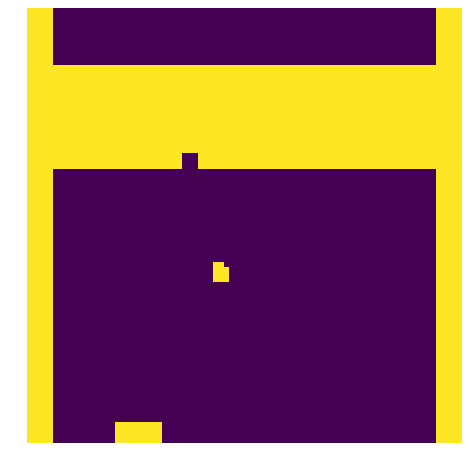

In [18]:
plot_state(history["input"][150].reshape(84,84))

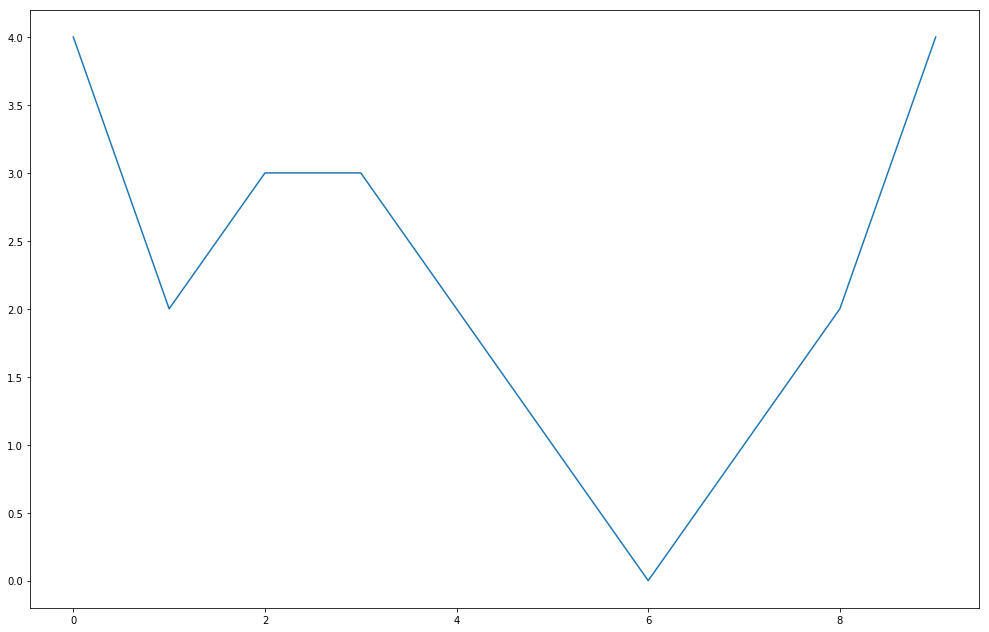

In [19]:
plt.figure(figsize=(17,11))
plt.plot(episode_scores)
plt.show()

# Saving Model

In [20]:
model.save("breakout-atari-rl.h5")

# Testing the Model

In [21]:
mod = load_model("breakout-atari-rl.h5")

/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


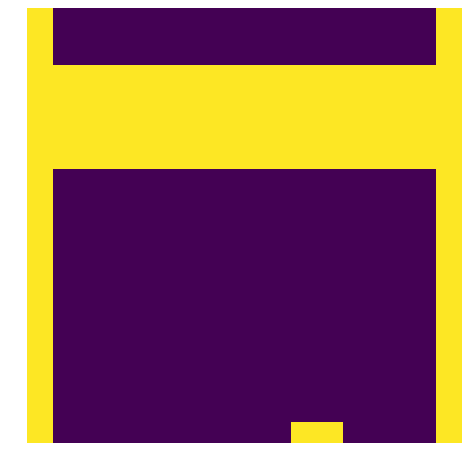

Welcome to AI Breakout!
Starting Game 1 of 20...
Total game score was: 5

Welcome to AI Breakout!
Starting Game 2 of 20...
Total game score was: 4

Welcome to AI Breakout!
Starting Game 3 of 20...
Total game score was: 2

Welcome to AI Breakout!
Starting Game 4 of 20...
Total game score was: 3

Welcome to AI Breakout!
Starting Game 5 of 20...
Total game score was: 4

Welcome to AI Breakout!
Starting Game 6 of 20...
Total game score was: 4

Welcome to AI Breakout!
Starting Game 7 of 20...
Total game score was: 4

Welcome to AI Breakout!
Starting Game 8 of 20...
Total game score was: 3

Welcome to AI Breakout!
Starting Game 9 of 20...


KeyboardInterrupt: 

In [22]:
env = gym.make("Breakout-v0")
observation = env.reset()
observation, lives = process_obs(observation)

plot_state(observation.reshape((84,84)))

episodes = 20
done = False
epsilon = 0


for i in range(1, episodes):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...".format(i, episodes))
    
    sum = 0
    game = True
    obs = []
    while game:
        
        if (len(obs) == 0):
            action = 1
        elif (len(obs) > 1) and (np.array_equal(obs[-1],obs[-2])):
            action = 1
        else:
            rand = np.random.uniform(0,1)
            if  rand < epsilon:
                action = env.action_space.sample()
            else:
                observation = np.expand_dims(observation,0)
                action = np.argmax(mod.predict(observation))
            
        #print(action)
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        obs.append(observation)

        sum += reward
        time.sleep(0.02)
        env.render()

        if done:
            print("Total game score was: {}\n".format(int(sum)))
            observation = env.reset()
            observation, lives = process_obs(observation)
            game = False
env.close()        